In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 样本

## 样本生成
用于生成（0,1]间的随机数  
缺点：不能很好的控制各亚组的样本数量

In [45]:
np.random.seed(45)

In [46]:
m0=2
N=500
P=2
M=2#真实的亚组数目
tp=0.101#惩罚系数
Ca=1#惩罚系数
weight=[ 0.7 , 0.3 ]#真实权重
mean=[-1 ,  1.5 ]#真实均值
covs=[1 , 1  ]#真实标准差
Theta=np.array([weight,mean,covs])
Theta#混合高斯分布的参数，mean越靠近且离散程度越大，区分的难度越大

array([[ 0.7,  0.3],
       [-1. ,  1.5],
       [ 1. ,  1. ]])

In [47]:
#定义各组样本量的界点
subnum=np.zeros(M-1)
subnum[0]=N*weight[0]
weight1=np.zeros(M+1)
weight1[0]=0
weight1[M]=1
for i in range(1,M-1):
    subnum[i]=subnum[i-1]+N*weight[i]
for i in range(1,M):
    weight1[i]=np.sum(weight[:i])

In [48]:
mu=np.array([0,0])
cov=np.array([[2,1],[1,2]])
X=np.random.multivariate_normal(mu,cov,N,check_valid='raise')
betat=np.random.uniform(0,1,P)#真实的斜率
betat

array([0.6465484 , 0.94609322])

In [5]:
Y=np.zeros((N,2))#随机生成样本
for i in range(N):
    a=np.random.rand()
    for j in range(M):
        if a>=weight1[j] and a<=weight1[j+1]:
            Y[i,0]=np.dot(X[i],betat)+np.random.normal(Theta[1,j],Theta[2,j])
            Y[i,1]=j

## 展示样本

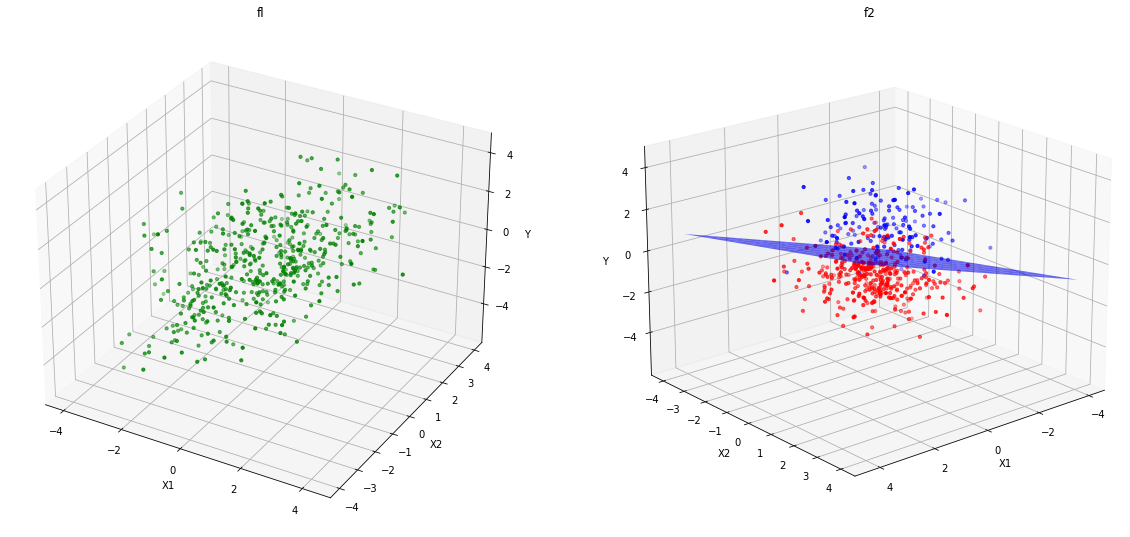

In [7]:
cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'cyan', 4:'brown',5:'burlywood'}

fig = plt.figure(figsize=(20,10))

xm = np.linspace(-4,4,10)
ym = np.linspace(-4,4,10)
Xm, Ym = np.meshgrid(xm, ym)

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X[:,0], X[:,1],Y[:,0] ,c = 'g', s = 10)
ax1.set_zlabel('Y')  # 坐标轴
ax1.set_ylabel('X2')
ax1.set_xlabel('X1')
ax1.set_title('fl')

ax2 = fig.add_subplot(122, projection='3d')
for g in np.unique(Y[:,1]):
    ix = np.where(Y[:,1] == g)
    ax2.scatter(X[ix,0], X[ix,1],Y[ix,0] ,c = cdict[g], label = g, s = 10)

ax2.plot_surface(Xm,Ym,Z=betat[0]*Xm+betat[1]*Ym, color='b',alpha=0.6,label='True beta')
ax2.set_zlabel('Y')  # 坐标轴
ax2.set_ylabel('X2')
ax2.set_xlabel('X1')
ax2.view_init(elev=20,azim=50)
ax2.set_title('f2')
plt.show()

# H0m=m0 v.s. H1:m>m0 下的参数估计

In [8]:
def normal(x,theta):
    mu=theta[0]
    s=theta[1]#标准差
    result=(1/(np.sqrt(2*np.pi)*s))*np.exp(-1*(x-mu)**2/(2*s**2))
    return result

def mixnormal(x,theta):
    m=theta.shape[1]
    result=0
    for i in range(m):
        result+=theta[0,i]*normal(x,theta[1:,i])
    return result

def Lih(X,theta):
    num=X.shape[0]
    C=theta.shape[1]
    Ga=np.zeros((num,C))
    c=np.zeros(C)

    for j in range(num):#响应度
        for k in range(C):
            c[k]=theta[0,k]*normal(X[j],theta[1:,k])
        Ga[j]=c/np.sum(c)

    return Ga

In [9]:
def ps(x,y,an=0.25):#对方差的惩罚函数
    z=-an*(np.log(x**2/y**2)+(y**2/x**2)-1)
    return z

def pa(α):#对系数的惩罚函数
    z=Ca*np.log(1-abs(1-2*α))
    return z

## H0下的最大惩罚似然计算

In [10]:
'''
原假设下的惩罚对数似然,这里只对方差惩罚，不对α惩罚
因为H0为m=1时有惩罚似然最大中在α=0.5取到，自然设置α=0.5
H0为m=m0>=2时，有充分的理由认为不会发生不可识别问题，即αh(h=1,2,...,m0)不会落在界点上
'''
def pl0(data,theta,tp):
    n=data.shape[0]
    m=theta.shape[1]
    y=np.zeros(n)
    ssvar=np.var(data)
    a=0
    for h in range(m):
        a+=ps(theta[2,h],ssvar,tp)
    for i in range(n):
        y[i]=np.log(mixnormal(data[i],theta))
    z=np.sum(y)+a
    return z

In [11]:
def ECMforH0(Xs,Y,betaold,thetaold,theta0):
    P=Xs.shape[1]
    num=Xs.shape[0]
    data=Y-np.dot(Xs,betaold.T)
    L0=Lih(data,thetaold)
    C=thetaold.shape[1]
    d=np.zeros(C)
    thetanext=np.zeros((3,C))

    ai=np.zeros(num)
    bi=np.zeros(num)
    for i in range (num):
        for h in range(C):
            bi[i]+=(L0[i,h])/((thetaold[2,h])**2)
            ai[i]+=((L0[i,h])*((Y[i]-thetaold[1,h])))/((thetaold[2,h])**2)

    xnew=np.zeros((num,P))
    for i in range(num):
        xnew[i]=Xs[i]*bi[i]

    betanew=np.dot(np.dot(np.linalg.inv(np.dot(xnew.T,Xs)),Xs.T),ai)

    datanew=Y-np.dot(Xs,betanew.T)
    for k in range(C):#更新参数
        d[k]=np.sum(L0[:,k])
        thetanext[0,k]=d[k]/num
        thetanext[1,k]=np.dot(L0[:,k],datanew[:])/d[k]
        thetanext[2,k]=np.sqrt((np.dot(L0[:,k],(datanew[:]-thetanext[1,k])**2)+2*tp*theta0[2,k])/(d[k]+2*tp))#标准差

    return betanew,thetanext


In [12]:
def iterECMforH0(Xs,Y,beta0,theta0,N=1000,stopbyN= False,ε=0.0005):
    T0=[beta0,theta0]
    exitflag=False
    c=0
    if stopbyN == True:
        for i in range(N):
            a=T0
            T0=ECMforH0(Xs,Y,T0[0],T0[1],theta0)
            c=np.linalg.norm(T0[0]-a[0])

    else:
        for i in range(N):
            if exitflag == True:
                break
            a=T0
            T0=ECMforH0(Xs,Y,T0[0],T0[1],theta0)
            if (np.linalg.norm(T0[0]-a[0])/(np.linalg.norm(a[0])+0.0001)) <= ε:
                c=np.linalg.norm(T0[0]-a[0])
                exitflag = True

    return T0,c,i

### 获取H0下的最优估计

#### beta的初值

In [13]:
#beta的初值根据对全体样本做最小二乘确定
model = LinearRegression() # 构建线性模型
model.fit(X, Y[:,0]) # 自变量在前，因变量在后
beta0 = model.coef_ # 斜率
intercept = model.intercept_ # 截距
print(betat,'\n',model.coef_, model.intercept_) # 输出斜率和截距

[0.45368403 0.26354917] 
 [0.35959231 0.38982286] -0.24063577737617084


#### 其他参数的初值选取

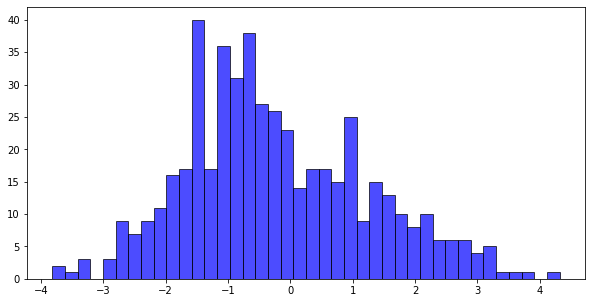

In [14]:
data0=np.zeros(N)
for i in range(N):
    data0[i]=Y[i,0]-np.dot(X[i],beta0)

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot()
ax1.hist(data0, bins=40,  facecolor="blue", edgecolor="black", alpha=0.7)
plt.show()

#### H0:m=1

#### H0:m>=2（待改进）

In [15]:

weight0=[0.6,0.4]
mean0=[-1,1]
#分位数定均值初值
covs0=[1,1]
theta0=np.array([weight0,mean0,covs0])

In [16]:
print(' 初值:\n','β初值:',beta0,'\n','参数初值:\n',theta0,'\n','-'*50,'\n','真值：\n','β真值:',betat,'\n','参数真值:\n',Theta)

 初值:
 β初值: [0.35959231 0.38982286] 
 参数初值:
 [[ 0.6  0.4]
 [-1.   1. ]
 [ 1.   1. ]] 
 -------------------------------------------------- 
 真值：
 β真值: [0.45368403 0.26354917] 
 参数真值:
 [[ 0.7  0.3]
 [-1.   1.5]
 [ 1.   1. ]]


In [17]:
result=iterECMforH0(X,Y[:,0],beta0,theta0,100,True)
print(' 收敛值:\n','β收敛值:',result[0][0],'\n','参数收敛值:\n',result[0][1],'\n最后两次迭代间β的‘差距’\n',result[1],'迭代停止次数：',result[2])

 收敛值:
 β收敛值: [0.40553816 0.35909224] 
 参数收敛值:
 [[ 0.68465946  0.31534054]
 [-0.98849873  1.37151853]
 [ 0.94137925  1.0618346 ]] 
最后两次迭代间β的‘差距’
 6.112296414287979e-06 迭代停止次数： 99


In [18]:
betaH0=result[0][0]
thetaH0=result[0][1]

In [19]:
data2=np.zeros(N)
for i in range(N):
    data2[i]=Y[i,0]-np.dot(X[i],betaH0)

In [20]:
#H0下的惩罚似然
sr01=pl0(data2,result[0][1],tp)
sr01

-884.7883900197313

## H1下的似然计算

#混合正态的惩罚联合对数似然,注意这里的x为Yi-Xi.T*beta,k表示第k个初始值
def pl1(k,data,theta,th0,C=1):
    n=data.shape[0]
    m=th0.shape[1]
    y=np.zeros(n)
    a=0
    for h in range(m):
        a+=ps(theta[2,(2*h)],th0[2,h],tp)+ps(theta[2,(2*h+1)],th0[2,h],tp)+pa(theta[0,2*h],C)+pa(theta[k,(2*h+1)],C)
    for i in range(n):
        y[i]=np.log(mixnormal(data[i],theta))
    z=np.sum(y)+a
    return z

In [21]:
#混合正态的惩罚联合对数似然,注意这里的x为Yi-Xi.T*beta
def pl1(k,data,theta,th0):
    n=data.shape[0]
    m=th0.shape[1]
    y=np.zeros(n)
    a=0
    for h in range(m):
        a+=ps(theta[2,(2*h)],th0[2,h],tp)+ps(theta[2,(2*h+1)],th0[2,h],tp)+pa(aa[k,h])
    for i in range(n):
        y[i]=np.log(mixnormal(data[i],theta))
    z=np.sum(y)+a
    return z

In [22]:
#用来对固定权重迭代参数的ECM，不更新权重
def ECMff(Xs,Y,we,betaold,thetaold,theta0):
    P=Xs.shape[1]
    num=Xs.shape[0]
    data=Y-np.dot(Xs,betaold.T)
    L0=Lih(data,thetaold)
    C=int(thetaold.shape[1])
    C0=int(C/2)
    d=np.zeros(C)
    thetanext=np.zeros((3,C))
    thetanext0=np.zeros((3,C0))

    ai=np.zeros(num)
    bi=np.zeros(num)
    for i in range (num):
        for h in range(C):
            bi[i]+=(L0[i,h])/((thetaold[2,h])**2)
            ai[i]+=((L0[i,h])*((Y[i]-thetaold[1,h])))/((thetaold[2,h])**2)

    xnew=np.zeros((num,P))
    for i in range(num):
        xnew[i]=Xs[i]*bi[i]

    betanew=np.dot(np.dot(np.linalg.inv(np.dot(xnew.T,Xs)),Xs.T),ai)
    datanew=Y-np.dot(Xs,betanew.T)
    '''
    以上为更新beta的部分，下面为更新混合正态的部分
    '''
    for l in range(C0):
        d[2*l]=np.sum(L0[:,2*l])
        d[2*l+1]=np.sum(L0[:,2*l+1])
        thetanext0[0,l]=(d[2*l]+d[2*l+1])/num
        thetanext[0,2*l]=thetanext0[0,l]*we[l]
        thetanext[0,2*l+1]=thetanext0[0,l]*(1-we[l])

    for k in range(C):#更新参数
        thetanext[1,k]=np.dot(L0[:,k],datanew[:])/d[k]
        thetanext[2,k]=np.sqrt((np.dot(L0[:,k],(datanew[:]-thetanext[1,k])**2)+2*tp*theta0[2,k])/(d[k]+2*tp))#标准差

    return betanew,thetanext


In [23]:
def iterECMff(Xs,Y,beta0,theta0,N=1000,stopbyN= False,ε=0.005):
    C0=int(theta0.shape[1]/2)
    we=np.zeros(C0)
    for l in range(C0):
        we[l]=(theta0[0,2*l])/(theta0[0,2*l]+theta0[0,2*l+1])
    T0=[beta0,theta0]
    exitflag=False
    c=0
    if stopbyN == True:
        for i in range(N):
            a=T0
            T0=ECMff(Xs,Y,we,T0[0],T0[1],theta0)

    else:
        for i in range(N):
            if exitflag == True:
                break
            a=T0
            T0=ECMff(Xs,Y,we,T0[0],T0[1],theta0)
            if (np.linalg.norm(T0[0]-a[0])/(np.linalg.norm(a[0])+0.001)) <= ε:
                c=np.linalg.norm(T0[0]-a[0])
                exitflag = True

    return T0,c,i

In [24]:
#对于H1下的一次迭代的参数估计
def ECMforH1(Xs,Y,betaold,thetaold,theta0,s=1):
    P=Xs.shape[1]
    num=Xs.shape[0]
    data=Y-np.dot(Xs,betaold.T)
    L0=Lih(data,thetaold)
    C=int(thetaold.shape[1])
    C0=int(C/2)
    d=np.zeros(C)
    thetanext=np.zeros((3,C))
    thetanext0=np.zeros((3,C0))

    ai=np.zeros(num)
    bi=np.zeros(num)
    for i in range (num):
        for h in range(C):
            bi[i]+=(L0[i,h])/((thetaold[2,h])**2)
            ai[i]+=((L0[i,h])*((Y[i]-thetaold[1,h])))/((thetaold[2,h])**2)

    xnew=np.zeros((num,P))
    for i in range(num):
        xnew[i]=Xs[i]*bi[i]

    betanew=np.dot(np.dot(np.linalg.inv(np.dot(xnew.T,Xs)),Xs.T),ai)
    datanew=Y-np.dot(Xs,betanew.T)
    '''
    以上为更新beta的部分，下面为更新混合正态的部分
    '''
    for l in range(C0):
        d[2*l]=np.sum(L0[:,2*l])
        d[2*l+1]=np.sum(L0[:,2*l+1])
        thetanext0[0,l]=(d[2*l]+d[2*l+1])/num
        if (d[2*l]/(d[2*l]+d[2*l+1])) <= 0.5:
            if (d[2*l]+Ca)/((d[2*l]+d[2*l+1])+Ca) <= 0.5:
                thetanext[0,2*l]=((d[2*l]+Ca)/((d[2*l]+d[2*l+1])+Ca))*thetanext0[0,l]
                thetanext[0,2*l+1]=((d[2*l+1])/((d[2*l]+d[2*l+1])+Ca))*thetanext0[0,l]
            else:
                thetanext[0,2*l]=0.5*thetanext0[0,l]
                thetanext[0,2*l+1]=0.5*thetanext0[0,l]
        else:
            if (d[2*l])/((d[2*l]+d[2*l+1])+Ca) > 0.5:
                thetanext[0,2*l]=((d[2*l])/((d[2*l]+d[2*l+1])+Ca))*thetanext0[0,l]
                thetanext[0,2*l+1]=((d[2*l+1]+Ca)/((d[2*l]+d[2*l+1])+Ca))*thetanext0[0,l]
            else:
                thetanext[0,2*l]=0.5*thetanext0[0,l]
                thetanext[0,2*l+1]=0.5*thetanext0[0,l]

    for k in range(C):#更新参数
        thetanext[1,k]=np.dot(L0[:,k],datanew[:])/d[k]
        thetanext[2,k]=np.sqrt((np.dot(L0[:,k],(datanew[:]-thetanext[1,k])**2)+2*tp*theta0[2,k])/(d[k]+2*tp))#标准差

    return betanew,thetanext


In [25]:
def iterECMforH1(Xs,Y,beta0,theta0,N=1000,stopbyN= False,ε=0.005):
    T0=[beta0,theta0]
    exitflag=False
    c=0
    if stopbyN == True:
        for i in range(N):
            a=T0
            T0=ECMforH1(Xs,Y,T0[0],T0[1],theta0)

    else:
        for i in range(N):
            if exitflag == True:
                break
            a=T0
            T0=ECMforH1(Xs,Y,T0[0],T0[1],theta0)
            if (np.linalg.norm(T0[0]-a[0])/(np.linalg.norm(a[0])+0.001)) <= ε:
                c=np.linalg.norm(T0[0]-a[0])
                exitflag = True

    return T0,c,i

### step 0 设定不同的初值
m0个数组的排列问题  
当m0为确定的数时，只需要套m0个循环即可  
如果m0未知，无法用上述想法做了，可以将循环问题转为递归问题  
或者用查询的方法做

In [26]:
Weight=np.array([0.1,0.9,0.3,0.7,0.5])
Weight0=np.zeros((5**m0,2*m0))#H1下的初始权重
aa=np.zeros((5**m0,m0))

In [27]:
for i in range (5**m0):
    for j in range(m0):
        a=np.floor(i/(5**(m0-j-1)))
        if a>4:
            a=a-5*np.floor(a/5)
        b=int(a)
        aa[i,j]=Weight[b]
        Weight0[i,2*j]=Weight[b]*thetaH0[0,j]
        Weight0[i,2*j+1]=(1-Weight[b])*thetaH0[0,j]

### step 1 固定参数的不同初值下，分别选取使得惩罚似然达到最大的正态参数
（ECMff多次迭代即可）

In [28]:
Theta

array([[ 0.7,  0.3],
       [-1. ,  1.5],
       [ 1. ,  1. ]])

In [29]:
thetaH0

array([[ 0.68465946,  0.31534054],
       [-0.98849873,  1.37151853],
       [ 0.94137925,  1.0618346 ]])

In [30]:
#thetan=np.array((Weight0[i],[-2,2],[1,1]))
#thetan=np.array((Weight0[i],[-3,-1,1,3],[1,1,1,1]))
Th=np.zeros((5**m0,3,2*m0))
Be=np.zeros((5**m0,P))
for i in range(5**m0):
    thetan=np.array((Weight0[i],[-1.5,0,1,2],[0.6,0.6,0.6,0.6]))
    res=iterECMff(X,Y[:,0],betaH0,thetan,20,True)
    Th[i]=res[0][1]
    Be[i]=res[0][0]

'''
Th[i]表示第i个权重初值下的最佳参数初值  
Be[i]表示第i个权重初值下的最佳斜率初值  
以上均作为最早的初值参与迭代
'''

'\nTh[i]表示第i个权重初值下的最佳参数初值  \nBe[i]表示第i个权重初值下的最佳斜率初值  \n以上均作为最早的初值参与迭代\n'

### step 2 分别选定初始参数后的迭代（只需迭代几次）

In [31]:
rs=np.zeros(5**m0)
Th1=np.zeros((5**m0,3,2*m0))
Be1=np.zeros((5**m0,P))
for i in range(5**m0):
    res=iterECMforH1(X,Y[:,0],Be[i],Th[i],3,True)
    Th1[i]=res[0][1]
    Be1[i]=res[0][0]
    da=np.zeros(N)
    for j in range(N):
        da[j]=Y[j,0]-np.dot(X[j],Be1[i])
    rs[i]=pl1(i,da,Th1[i],thetaH0)

In [32]:
2*(rs-sr01)

array([-3.20485687, -1.22864044,  2.07118189,  3.86972509,  4.44309828,
       -4.39857379, -1.59873991,  0.75840587,  2.45339667,  3.20280661,
       -1.80376714,  1.1676482 ,  4.02999841,  6.11641781,  6.53606643,
       -2.57730037,  1.29410434,  3.07924061,  5.61275814,  5.84077987,
       -1.51826547,  2.10876915,  4.47633693,  6.90678636,  7.181268  ])

In [33]:
np.max(2*(rs-sr01))

7.181268001619401

df	0.995	0.99	0.975	0.95	0.90	0.10	0.05	0.025	0.01	0.005
4	0.207	0.297	0.484	0.711	1.064	7.779	9.488	11.143	13.277	14.860

In [34]:
np.where(2*(rs-sr01)==np.max(2*(rs-sr01)))

(array([24], dtype=int64),)

In [35]:
betat,Theta

(array([0.45368403, 0.26354917]),
 array([[ 0.7,  0.3],
        [-1. ,  1.5],
        [ 1. ,  1. ]]))

In [36]:
betaH0,thetaH0

(array([0.40553816, 0.35909224]),
 array([[ 0.68465946,  0.31534054],
        [-0.98849873,  1.37151853],
        [ 0.94137925,  1.0618346 ]]))

In [37]:
Be1[21],Th1[21]

(array([0.4200524 , 0.33720871]),
 array([[ 0.3323888 ,  0.3323888 ,  0.2933394 ,  0.041883  ],
        [-1.42354842, -0.71937742,  1.17731949,  2.9457691 ],
        [ 0.9001713 ,  0.66587624,  0.82557827,  0.48868739]]))

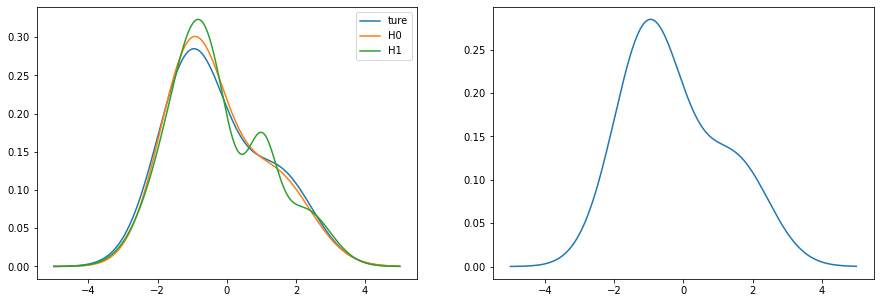

In [38]:
fig = plt.figure(figsize=(15,5))
x = np.linspace(-5,5,2000) # 从0到1，等分50分

c1 = mixnormal(x,Theta)
c2 = mixnormal(x,thetaH0)
c3 = mixnormal(x,Th1[24])

ax1 = fig.add_subplot(121)
ax1.plot(x,c1)
ax1.plot(x,c2)
ax1.plot(x,c3)
ax1.legend(['ture','H0','H1'])
ax2 = fig.add_subplot(122)
ax2.plot(x,c1)
plt.show()

### step 3
每次找出使得H1下惩罚似然达到最大的那个初始参数，计算对应的似然比统计量

# EM值计算

## ECM的迭代算法
```
def iterECM(Xs,Y,beta0,theta0,tp=0.002,N=1000,ε=0.005):
    T0=[beta0,theta0]
    for i in range(N):
        a=T0[0]
        T0=ECM(Xs,Y,T0[0],T0[1],theta0,tp)
        b=np.linalg.norm(T0[0]-a)
        '''
        if b<=ε:
            break
        '''
    return T0,b,i
```